# Simple linear regression

## Intro

### The SLE model

Suppose we have a simple labelled dataset with one feature $X$ and one target $Y$. Assume that both are continuous variables, and we have $m$ samples. According to our convention, we denote the $i$-th sample as $(x_i, y_i)$, where $x_i$ is the feature and $y_i$ is the target.

In **simple linear regression**, we assume that the relationship between $X$ and $Y$ is linear. That is, we assume that there exists a pair $\mathbf{w} = (b,w) \in \mathbb{R}^2$ (the parameters of the model) such that
\begin{align*}
    y_i & = F_{\mathbf{w}}(x_i) + \epsilon_i \\
    & = b + wx_i + \epsilon_i,
\end{align*}
where each $\epsilon_i$ is a small error term. (Later, we will be more precise on what exactly we mean by "small error term", but for now let's proceed with a vague idea.)

### Formula for MSE loss
The standard loss function for linear regression is the **mean squared error** (MSE). Recall that, if we denote each prediction as $\hat{y}_i = F_{\mathbf{w}}(x_i)$, then the MSE loss function is defined as
\begin{equation*}
    J(m,b) = \frac{1}{m} \sum_{i=1}^m \epsilon_i^2 = \frac{1}{m} \sum_{i=1}^m (y_i - (b + wx_i))^2. \tag{1}
\end{equation*}
Sometimes, we may also write it as $J(\mathbf{w})$.

### Fitting the model
This requires us to solve the following optimization problem: *Find the parameters $\hat{\mathbf{w}} = (\hat{b},\hat{w})$ which minimize $J(m,b)$, i.e. which satisfy*:
\begin{align*}
    \hat{\mathbf{w}} & = \argmin_{\mathbf{w} \in \mathbb{R}^2} \; J(\mathbf{w})
\end{align*}
The graph of the fitted function $F_{\hat{\mathbf{w}}}$ is called the **regression line** or **line of best fit**. 

### Generating a synthetic dataset
In this notebook, we will derive the formulas for $\hat{\mathbf{w}}$ in two ways, first using calculus, and then using linear algebra. Before any of that, however, we first generate a synthetic dataset of points to work with. That is, we construct a set of points on a line and then add in some noise. This will be convenient because we will know the "true" linear relationship in our data, and we can compare it with the line of best fit that we will derive.

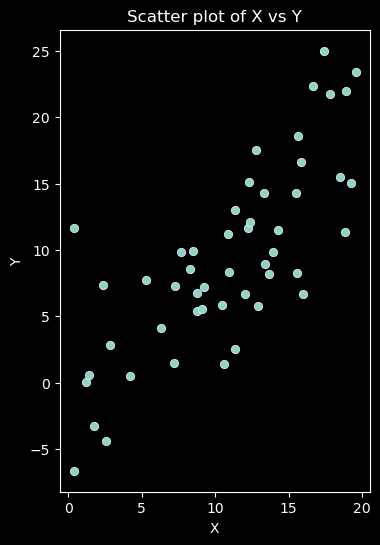

,X,Y
0,0.375796,-6.630714
1,0.404368,11.677371
2,1.204509,0.015347
3,1.420721,0.546205
4,1.742586,-3.269908


In [9]:
# Generate 50 random x values between 0 and 20. Generate corresponding y values using the function y = 2x + 1. Add some noise to the y values.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(0)
# Generate random x values and sort in ascending order
x = np.random.uniform(0, 20, 50)
x.sort()
# Generate residuals
residuals = np.random.normal(0, 5, 50)
# Generate y values using the function y = 0.8x + 1.6 and add noise
y = 0.8* x + 1.6 + residuals
# Create a DataFrame
df = pd.DataFrame({'X': x, 'Y': y})

# Plot the data using seaborn
plt.figure(figsize=(4, 6))
sns.scatterplot(data=df, x='X', y='Y')
#add labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of X vs Y')
plt.show()

df.head()

## Fitting 1: Calculus

### Visualizing residuals

Below, we add a nice animation illustrating how residuals, and the corresponding MSE, change as we move the regression line. The animation is created using the `manim` library made by the creator of 3Blue1Brown (the greatest math-video channel to have existed). If you want to run it, you can install it with `conda install manim`. 

In [2]:
# use manim to create a nice scatterplot of the data
from manim import *
config.verbosity = "ERROR"

class ScatterPlotWithMovingLineAndParameters(Scene):
    def construct(self):
        # Create axes with numbers and labels (using original parameters)
        axes = Axes(
            x_range=[0, 20, 5],
            y_range=[-5, 30, 5],
            x_length=10,
            y_length=6,
            axis_config={"include_numbers": True, "font_size": 30},
        )
        axes.scale(0.9)
        x_label = axes.get_x_axis_label("X")
        y_label = axes.get_y_axis_label("Y")
        
        # Create scatter points (df is assumed to be defined)
        points = [
            axes.c2p(x_val, y_val)
            for x_val, y_val in zip(df['X'], df['Y'])
        ]
        scatter_points = VGroup(*[Dot(point=point) for point in points])
        
        # Add axes, numbers, and labels to the scene
        self.play(Create(axes), Write(x_label), Write(y_label), run_time=1)
        self.wait(1)
        self.play(FadeIn(scatter_points), run_time=1)
        self.wait(2)
        
        # Use ValueTrackers for m and b (initially m = 0.5, b = 1)
        m_tracker = ValueTracker(0.5)
        b_tracker = ValueTracker(1)
        
        # Always redraw the line using current m and b values.
        line = always_redraw(lambda: axes.plot(
            lambda x: m_tracker.get_value() * x + b_tracker.get_value(),
            x_range=[0, 20],
            color=BLUE
        ))
        
        self.play(Create(line), run_time=2)
        
        # Fixed label for the line equation below the x-axis. It updates automatically.
        eq_label = always_redraw(lambda: MathTex(
            "y =",
            f"{m_tracker.get_value():.1f}x",
            "+",
            f"{b_tracker.get_value():.1f}"
        ).next_to(axes, UP))
        
        self.play(Write(eq_label), run_time=1)
        self.wait(2)
        
        # Animate changes in the line parameters (the equation updates automatically)
        self.play(
            m_tracker.animate.set_value(1.5),
            b_tracker.animate.set_value(-2),
            run_time=3
        )
        self.wait(2)
        
        self.play(
            m_tracker.animate.set_value(-0.5),
            b_tracker.animate.set_value(10),
            run_time=3
        )
        self.wait(2)

%manim -qh ScatterPlotWithMovingLineAndParameters

Manim Community v0.19.0

### Directional derivatives

The MSE loss function is a function of two variables, $m$ and $b$, so we can visualize it's graph as a surface in 3D space. The gradient of our loss function, 
\begin{equation*}
    \nabla J(m,b) = \begin{bmatrix} \; \frac{\partial J}{\partial m} & \frac{\partial J}{\partial b} \; \end{bmatrix},
\end{equation*}
is a vector in the $(m,b)$-plane which captures the instantaneous rate of change of $J$ at any given point. But what exactly does this mean? 

Well, if we choose a particular point $\mathbf{w}_0 = (m_0,b_0) \in \mathbb{R}^2$, then we can move in any direction on the plane. The direction is represented uniquely by a unit vector $\mathbf{u} \in \mathbb{R}^2$. Then, the rate of change of $J$ in the direction of $\mathbf{u}$ (also knows as the **directional derivative** of $J$ with respect to $\mathbf{u}$ at $\mathbf{w}_0$) is given by the dot product
\begin{align*}
    \nabla_{\mathbf{u}} J(\mathbf{w}_0) & \coloneqq \nabla J(\mathbf{w}_0) \cdot \mathbf{u} \\
                                        & = \begin{bmatrix} \; \frac{\partial J}{\partial m} & \frac{\partial J}{\partial b} \; \end{bmatrix} \cdot \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} \\
                                        & = \frac{\partial J}{\partial m} u_1 + \frac{\partial J}{\partial b} u_2.
\end{align*}
The notation above might be a little confusing; $\nabla_{\mathbf{u}} J(\mathbf{w})$ should be thought of as a new function from $\mathbb{R}^2$ to $\mathbb{R}$, which takes in a point $\mathbf{w} = \mathbf{w}_0$ and outputs the directional derivative along $\mathbf{u}$ at that point.
The interpretation of the directional derivative is then very similar to the interpretation of the classical one-variable derivative: if we move from $\mathbf{w}_0$ to $\mathbf{w}_0 + \epsilon \mathbf{u}$, then the change in $J$ is approximately equal to the directional derivative $\epsilon \nabla_{\mathbf{u}} J(\mathbf{w}_0)$. Thus, the dot product is used to incorporate the direction of movement into the rate of change!

### Gradients and minima
Suppose we are at some point $\mathbf{w}_0 \in \mathbb{R}^2$. Observe that as we vary our direction of movement $\mathbf{u}$, the directional derivative $\nabla J(\mathbf{w}_0) \cdot \mathbf{u}$ can be positive, negative, or zero. In particular, we have
\begin{equation*}
    - || \nabla J(\mathbf{w}_0)|| \leq \nabla_{\mathbf{u}} J(\mathbf{w}_0) \leq ||\nabla J(\mathbf{w}_0)||.
\end{equation*}
This follows from the fact that the dot product of two vectors is the product of their magnitudes, times the cosine of the angle between them. Thus:

- If the angle between $\nabla J(\mathbf{w}_0)$ and $\mathbf{u}$ is acute, then the directional derivative is positive. It is maximized when $\mathbf{u}$ is in the same direction as $\nabla J(\mathbf{w}_0)$. In particular **the gradient $\nabla J(\mathbf{w}_0)$ points in the direction of steepest ascent of $J$ at $\mathbf{w}_0$**. That is, it tells us the most *efficient way* to adjust the parameters $(b_0,m_0)$ so as to increase the loss $J$.
- If the angle between $\nabla J(\mathbf{w}_0)$ and $\mathbf{u}$ is obtuse, then the directional derivative is negative. It is minimized when $\mathbf{u}$ is in the opposite direction as $\nabla J(\mathbf{w}_0)$. In particular **the gradient $\nabla J(\mathbf{w}_0)$ points in the direction of steepest descent of $J$ at $\mathbf{w}_0$**. That is, it tells us the most *efficient way* to adjust the parameters $(b_0,m_0)$ so as to decrease the loss $J$. This is what we ultimately will use to train complicated models.

As a consequence of the above facts, we can cook up a "pure thought" argument for why the gradient needs to be the zero vector at any local minimum or maximum of $J$. It goes as follows. Suppose $J$ attains a local minimum at the point $\mathbf{w}_0$. Then, for *any* direction $\mathbf{u}$, the directional derivative $\nabla_{\mathbf{u}} J(\mathbf{w}_0)$ must be non-negative. Taking the reverse direction $-\mathbf{u}$, we see that the directional derivative $\nabla_{-\mathbf{u}} J(\mathbf{w}_0) = - \nabla_{\mathbf{u}} J(\mathbf{w}_0)$ must also be non-negative. Thus, we have 
\begin{equation*}
    \nabla_{\mathbf{u}} J(\mathbf{w}_0) = \nabla J(\mathbf{w}_0) \cdot \mathbf{u} = 0, \quad \textup{ for all } \mathbf{u} \in \mathbb{R}^2.
\end{equation*}
The only vector whose dot product with every other vector is zero is the zero vector itself. Thus, we conclude that at any local minimum $\mathbf{w}_0$, the gradient $\nabla J(\mathbf{w}_0) = \mathbf{0} \in \mathbb{R}^2$!

### Visualizing the loss surface
Below, we give a nice animation illustrating how the loss surface looks like, and how the negative gradient always points in the direction of steepest ascent. 

In [ ]:
# code for the manim animation of J(m,b) goes here

### Finding the minimum using calculus
Now, we are ready to find the minimum of the loss function $J(m,b)$. We will do this by setting the gradient $\nabla J(m,b)$ to zero. This will yield a system of two linear equations in $m$ and $b$, and we will solve this to extract the desired values $\hat{m}$ and $\hat{b}$. It will be helpful to use some facts about partial derivatives of vectors and dot products.

Suppose we have a vector-valued function $\mathbf{f}: \mathbb{R} \to \mathbb{R}^m$, defined by $\mathbf{f}(w) = \begin{bmatrix} f_1(w) \\ f_2(w) \\ \vdots \\ f_m(w) \end{bmatrix}^T$. Then, the **derivative of $\mathbf{f}$ with respect to $w$** is defined to be the vector-valued function $d\mathbf{f}/dw : \mathbb{R} \to \mathbb{R}^m$ given by
\begin{equation*}
    \frac{d\mathbf{f}}{dw} = \begin{bmatrix} \frac{df_1}{dw} \\ \frac{df_2}{dw} \\ \vdots \\ \frac{df_m}{dw} \end{bmatrix}^T.
\end{equation*}
(NOTE: we implicitly assume here that all these derivatives exist, in which case we say that "\mathbf{f}$ is differentiable".)
Given two such functions $\mathbf{f},\mathbf{g}: \mathbb{R} \to \mathbb{R}^m$, the **dot product of $\mathbf{f}$ and $\mathbf{g}$** is the scalar function $\mathbf{f} \cdot \mathbf{g} : \mathbb{R} \to \mathbb{R}$ given by
\begin{equation*}
    (\mathbf{f} \cdot \mathbf{g})(w) = f_1g_1(w) + \dotsb + f_mg_m(w).
\end{equation*}
Then, we have the following **product rule for dot products** (which you will prove in HW 1):
\begin{lem}
    Let $\mathbf{f},\mathbf{g}: \mathbb{R} \to \mathbb{R}^m$ be two differentiable vector-valued functions. Then, the derivative of the dot product $\mathbf{f} \cdot \mathbf{g}$ is given by
    \begin{equation*}
        \frac{d}{dw} (\mathbf{f} \cdot \mathbf{g}) = \frac{d\mathbf{f}}{dw} \cdot \mathbf{g} + \mathbf{f} \cdot \frac{d\mathbf{g}}{dw}.
    \end{equation*}
    In particular:
    \begin{enumerate}
        \item We have $d ||\mathbf{f}||^2 / dw = 2 \mathbf{f} \cdot d\mathbf{f}/dw$.
        \item If $\mathbf{g}$ is a constant vector, then $d(\mathbf{f} \cdot \mathbf{g}) / dw = \mathbf{g} \cdot d\mathbf{f}/dw$.
    \end{enumerate}
\end{lemma}

Similarly, for a vector-valued function $\mathbf{f}:\mathbb{R}^k \to \mathbb{R}^m$ defined by $f(\mathbf{w}) = \begin{bmatrix} \; f_1(\mathbf{w}) \dotsb f_m(\mathbf{w}) \; \end{bmatrix}^T$ (where $\mathbf{w} = (w_1,\dotsc,w_n)$), the **partial derivative of $\mathbf{f}$ with respect to $w_i$** is defined to be the vector-valued function $\partial \mathbf{f}/ \partial w_i : \mathbb{R} \to \mathbb{R}^m$ given by
\begin{equation*}
    \frac{\partial \mathbf{f}}{\partial w_i} = \begin{bmatrix} \frac{\partial f_1}{\partial w_i} \\ \frac{\partial f_2}{\partial w_i} \\ \vdots \\ \frac{\partial f_m}{\partial w_i} \end{bmatrix}^T.
\end{equation*}
Taking the dot product of these functions yields a scalar function $\mathbf{f} \cdot \mathbf{g} : \mathbb{R}^k \to \mathbb{R}$. Again, we have a similar lemma for partial derivatives of dot products (which you will also prove in HW 1):
\begin{lemma*}
    Let $\mathbf{f},\mathbf{g}: \mathbb{R}^k \to \mathbb{R}^m$ be two differentiable vector-valued functions. Then, the partial derivative of the dot product $\mathbf{f} \cdot \mathbf{g}$ with respect to $w_i$ is given by
    \begin{equation*}
        \frac{\partial}{\partial w_i} (\mathbf{f} \cdot \mathbf{g}) = \frac{\partial \mathbf{f}}{\partial w_i} \cdot \mathbf{g} + \mathbf{f} \cdot \frac{\partial \mathbf{g}}{\partial w_i}.
    \end{equation*}
    In particular:
    \begin{enumerate}
        \item We have $\partial ||\mathbf{f}||^2 / \partial w_i = 2 \mathbf{f} \cdot \partial \mathbf{f}/\partial w_i$.
        \item If $\mathbf{g}$ is a constant vector, then $\partial(\mathbf{f} \cdot \mathbf{g}) / \partial w_i = \mathbf{g} \cdot \partial \mathbf{f}/\partial w_i$.
    \end{enumerate}
\end{lemma*}
